In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os

In [34]:
# # ResNet18 구현에 관한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (피처맵 크기를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential() # identity인 경우. 비어있는 컨테이너이며, forward에서 x를 입력받아 residual 연산을 할 수 있도록 만든다.
        if stride != 1: # stride가 1이 아니라면, identity mapping이 아닌 경우이다. 이 경우에는 projection을 수행하여 forward에서 계산될 수 있도록 만든다.
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out)) # 여기까지가 F(x)
        out += self.shortcut(x) # F(x) + x
        out = F.relu(out)
        return out


In [35]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # CIFAR10: 3 x 32 x 32
        # 64개의 3x3 필터(filter)를 사용
        # (이미지의 첫 시작 채널 개수는 RGB라 3개, 그 다음은 64개의 필터를 만들 것이므로 64개로 out_channel을 설정한다)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) # shape=3x32x32 -> shape= 64x32x32
        self.bn = nn.BatchNorm2d(64) # BatchNorm의 첫 번째 매개변수는 입력 데이터의 채널 수이다.
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1) # shape= 64x32x32 -> shape= 64x32x32
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2) # shape= 64x32x32 -> shape= 128x16x16
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2) # shape= 128x16x16 -> shape= 256x8x8
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2) # shape= 256x8x8 -> shape= 512x4x4
        self.linear = nn.Linear(512, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        """
        strides = [1]
        strides = [2, 1]
        strides = [2, 1]
        strides = [2, 1]
        """
        strides = [stride] + ([1] * (num_blocks - 1))

        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride)) # 64, 64
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)


    # Outputsize = Inputsize / Poolingsize
    # tensor.view()
    def forward(self, x):
        out = self.bn(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4) # input tensor=512x4x4, kernel_size=4 -> 512x1x1
        out = out.view(out.size(0), -1) # 512x1x1 -> 512x1
        out = self.linear(out)

        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


### 데이터 셋 다운 및 로더 생성

In [36]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transfrom_test = transforms.Compose([
    transforms.ToTensor()   
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transfrom_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


### 훈련 및 테스트 

In [37]:
device = 'cuda'

net = ResNet18()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.1
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

def train(epoch):
    print('\n[ Train epoch: %d]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total_data_num = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # optimizer.zero_grad()
        for param in net.parameters():
            param.grad = None

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        _, predicted_idx = benign_outputs.max(1)

        total_data_num += targets.size(0) # 128
        correct += predicted_idx.eq(targets).sum().item() # 예측이 맞은 데이터의 개수를 correct에 더함

        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted_idx.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())
    
    total_train_accuracy = correct / total_data_num * 100.
    print('\nTotal benign train accuracy:', total_train_accuracy)
    print('Total benign train loss:', train_loss)

    return total_train_accuracy


def test(epoch):
    print('\n[ Test epoch: %d]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total_data_num = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total_data_num += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()


    total_test_accuracy = correct / total_data_num * 100.
    print('\nTest acuracy:', total_test_accuracy)
    print('Test average loss:', loss / total_data_num)

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    return total_test_accuracy


def adjust_learning_rate(optimizer, epoch): # Learning rate scheduler
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [38]:
train_accuracies = []
test_accuracies = []

for epoch in range(0, 200):
    adjust_learning_rate(optimizer, epoch)
    train_accuracies.append(train(epoch))
    test_accuracies.append(test(epoch))


[ Train epoch: 0]

Current batch: 0
Current benign train accuracy: 0.1015625
Current benign train loss: 2.334784984588623

Current batch: 100
Current benign train accuracy: 0.3125
Current benign train loss: 1.9909483194351196

Current batch: 200
Current benign train accuracy: 0.3359375
Current benign train loss: 1.79517662525177

Current batch: 300
Current benign train accuracy: 0.34375
Current benign train loss: 1.6984061002731323

Total benign train accuracy: 30.284
Total benign train loss: 769.2804585695267

[ Test epoch: 0]

Test acuracy: 36.36
Test average loss: 0.01884780024290085
Model Saved!

[ Train epoch: 1]

Current batch: 0
Current benign train accuracy: 0.3828125
Current benign train loss: 1.5822407007217407

Current batch: 100
Current benign train accuracy: 0.4296875
Current benign train loss: 1.5059665441513062

Current batch: 200
Current benign train accuracy: 0.4609375
Current benign train loss: 1.4823895692825317

Current batch: 300
Current benign train accuracy: 0.4

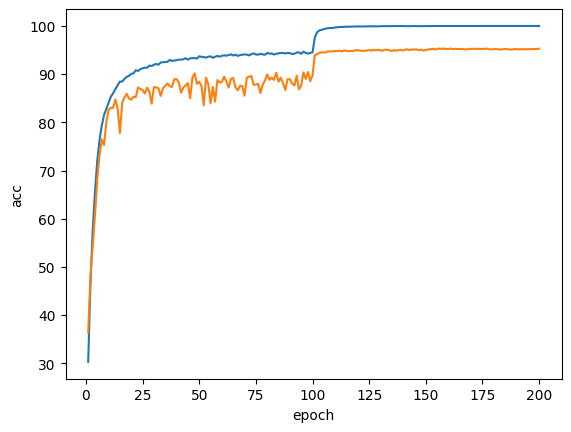

In [41]:
import matplotlib.pyplot as plt

plt.xlabel('epoch')
plt.ylabel('acc')
plt.plot(range(1, 201), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 201), test_accuracies, label='Test Accuracy')
plt.show()